In [112]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import os

In [226]:
#Cargamos el archivo a colab
df1 = pd.read_csv('NO12_EL_INDIO.csv', header =0)
#Quitamos valores incongruentes en precipitación
df2=df1.iloc[0:(len(df1)-1051), 1:]
print(len(df2))
train_dates = df1[['FECHA']]
df2.head()

2530


,TMED,PRCP,VELV,HUMR
0,18.14,0.0,6.10,29.43
1,13.70,0.0,6.72,40.64
2,15.46,0.0,6.88,41.50
3,17.37,0.0,8.52,35.68
4,22.44,0.0,16.49,30.19


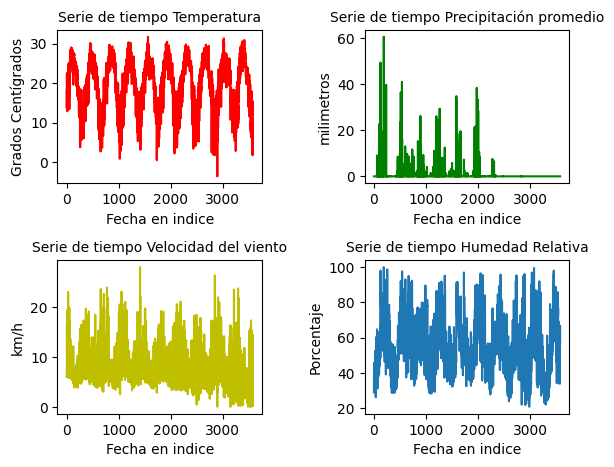

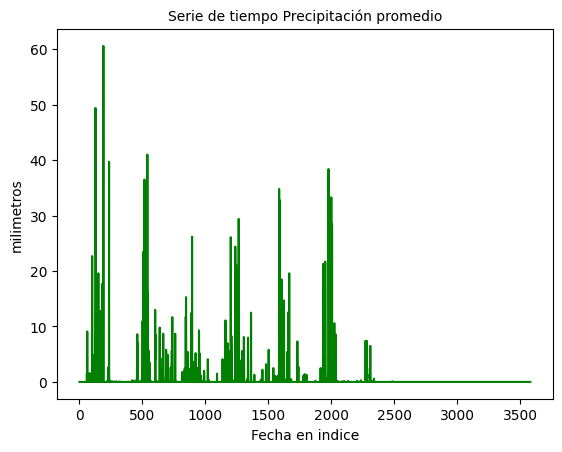

In [227]:
plt.subplot(2, 2, 1)
plt.plot(df1['TMED'],label= 'Temperatura media', color='r')
plt.xlabel("Fecha en indice")
plt.ylabel("Grados Centígrados")
plt.title("Serie de tiempo Temperatura",fontsize = 10)

plt.subplot(2, 2, 2)
plt.plot(df1['PRCP'], label = 'Precipitación promedio', color='g')
plt.xlabel("Fecha en indice")
plt.ylabel("milimetros")
plt.title("Serie de tiempo Precipitación promedio",fontsize = 10)

plt.subplot(2, 2, 3)
plt.plot(df1['VELV'], label = 'Velocidad del viento', color='y')
plt.xlabel("Fecha en indice")
plt.ylabel("km/h")
plt.title("Serie de tiempo Velocidad del viento",fontsize = 10)

plt.subplot(2, 2, 4)
plt.plot(df1['HUMR'], label = 'Humedad Relativa' )
plt.xlabel("Fecha en indice")
plt.ylabel("Porcentaje")
plt.title("Serie de tiempo Humedad Relativa",fontsize = 10)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.5,
                    hspace=0.5)

plt.show()
plt.plot(df1['PRCP'], label = 'Precipitación promedio', color='g')
plt.xlabel("Fecha en indice")
plt.ylabel("milimetros")
plt.title("Serie de tiempo Precipitación promedio",fontsize = 10)
plt.show()

In [228]:
#Remplazamos dichos valores con el valor del día anterior
def fill_missing(values):
    for row in range(df2.shape[0]):
        for col in range(df2.shape[1]):
            if np.isnan(values[row][col]):
                values[row,col] = values[row-1,col]
df2 = df2.astype('float32')
fill_missing(df2.values)
#Checamos que no haya ningun nan
df2.isnull().sum()

TMED    0
PRCP    0
VELV    0
HUMR    0
dtype: int64

In [224]:
#Cantidad de valores a evaluar
test_split=round(len(df2)*0.20)
test_split

506

In [117]:
#Dividimos en conjunto de entrenamiento y de evaluación
df_train=df2.iloc[:-test_split,0:]
df_test=df2.iloc[-test_split:,0:]
df_test.reset_index(inplace=True)
df_test= df_test.iloc[:,1:]
df_test.head()

,TMED,PRCP,VELV,HUMR
0,21.350000,1.5,4.46,79.930000
1,22.540001,0.0,5.18,74.440002
2,22.250000,0.0,4.84,74.650002
3,22.799999,0.0,4.80,74.290001
4,22.709999,0.0,5.61,77.089996


In [229]:
#Escalamiento de base de entrenamiento Input
sc=MinMaxScaler()
df_train_scaled=sc.fit_transform(df_train)
df_train_scaled
print(df_train_scaled.shape)
df_train_scaled

(2024, 4)


array([[0.56416   , 0.        , 0.13870335, 0.04210815],
       [0.42208   , 0.        , 0.16306484, 0.19437656],
       [0.47840002, 0.        , 0.16935167, 0.20605817],
       ...,
       [0.71360004, 0.        , 0.09351669, 0.5733497 ],
       [0.7792001 , 0.        , 0.0978389 , 0.48804674],
       [0.75616   , 0.1749175 , 0.23182714, 0.5605813 ]], dtype=float32)

In [119]:
#Escalamiento para el output
sc2=MinMaxScaler()
df_train_scaled_y=sc2.fit_transform(df_train[['PRCP']])
df_train_scaled_y
print(df_train_scaled_y.shape)

(2024, 1)


In [120]:
#Se crea los conjuntos de entrenamiento
hops=14
no_records=2024
no_cols=4
X_train=[]
y_train=[]
for i in range(14,2024):
  X_train.append(df_train_scaled[i-14:i])
  y_train.append(df_train_scaled_y[i][0])
X_train,y_train = np.array(X_train),np.array(y_train)
print(X_train.shape,y_train.shape)

(2010, 14, 4) (2010,)


In [121]:
X_train_shape = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],X_train.shape[2]))
X_train_shape.shape

(2010, 14, 4)

In [122]:
#Se crea la red neuronal LSTM
model=Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(14,4)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [123]:
#Se ajusta el modelo a los conjuntos de entrenamiento
model.fit(X_train_shape,y_train,epochs=100,batch_size=32)

Epoch 1/100
63/63 [==============================] - 7s 17ms/step - loss: 0.0049
Epoch 2/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0045
Epoch 3/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0045
Epoch 4/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0044
Epoch 5/100
63/63 [==============================] - 1s 16ms/step - loss: 0.0043
Epoch 6/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0044
Epoch 7/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0043
Epoch 8/100
63/63 [==============================] - 1s 17ms/step - loss: 0.0044
Epoch 9/100
63/63 [==============================] - 1s 16ms/step - loss: 0.0043
Epoch 10/100
63/63 [==============================] - 2s 27ms/step - loss: 0.0043
Epoch 11/100
63/63 [==============================] - 2s 27ms/step - loss: 0.0043
Epoch 12/100
63/63 [==============================] - 2s 26ms/step - loss: 0.0043
Epoch 13/100
63/63 [=====

In [124]:
#Se toman los últimos 14 valores
df_train_last14=df_train.iloc[-14:]
df1_test_full=df_test
full_df=pd.concat((df_train_last14,df1_test_full),axis=0)
print(full_df.shape)
full_df.head()

(520, 4)


,TMED,PRCP,VELV,HUMR
2010,21.340000,0.0,5.16,68.260002
2011,22.200001,0.0,5.10,71.349998
2012,23.100000,0.0,5.29,71.980003
2013,22.250000,0.0,6.87,72.379997
2014,23.709999,0.0,5.09,72.379997


In [125]:
full_df=sc.transform(full_df)
full_df.shape

(520, 4)

In [126]:
#Se realizan el conjunto para las predicciones
hops=14
no_records=520
no_cols=4
X_train_shape_pred=[]
for i in range(14,520):
  X_train_shape_pred.append(full_df[i-14:i])
X_train_shape_pred = np.array(X_train_shape_pred)
print(X_train_shape_pred.shape)

(506, 14, 4)


In [127]:
len(X_train_shape_pred)

506

In [128]:
#Se realiza la prediccion
ytest=model.predict(X_train_shape_pred)

16/16 [==============================] - 1s 5ms/step


In [129]:
#Se regresa a los valores originales
y_final_pred=sc2.inverse_transform(ytest)
y_final_pred

array([[ 1.88917983e+00],
       [ 1.83030260e+00],
       [ 1.56111836e+00],
       [ 1.48874295e+00],
       [ 1.49602163e+00],
       [ 1.61054039e+00],
       [ 1.55864167e+00],
       [ 1.55872118e+00],
       [ 1.57357371e+00],
       [ 1.68549097e+00],
       [ 2.53141212e+00],
       [ 2.30223680e+00],
       [ 1.90466738e+00],
       [ 1.81312740e+00],
       [ 1.34256637e+00],
       [ 1.13721263e+00],
       [ 9.85739648e-01],
       [ 8.25227082e-01],
       [ 9.64600980e-01],
       [ 2.01655006e+00],
       [ 2.05806994e+00],
       [ 1.59428596e+00],
       [ 8.74905705e-01],
       [ 6.24538243e-01],
       [ 9.03386593e-01],
       [ 8.97685885e-01],
       [ 6.77740335e-01],
       [ 6.14457786e-01],
       [ 5.42536676e-01],
       [ 4.61215019e-01],
       [ 3.79586160e-01],
       [ 3.29339832e-01],
       [ 2.69254774e-01],
       [ 2.85748363e-01],
       [ 2.87084728e-01],
       [ 3.45608145e-01],
       [ 3.34349632e-01],
       [ 2.38950998e-01],
       [ 3.3

In [202]:
#Se pasa a formato DataFrame
final_pr_pred = pd.DataFrame(y_final_pred)
final_pr_pred.columns=['final_pr_pred']
final_pr_pred

,final_pr_pred
0,1.889180
1,1.830303
2,1.561118
3,1.488743
4,1.496022
...,...
501,-0.146045
502,-0.008770
503,0.015365
504,-0.042494


In [203]:
#Se concatena con el resto de la base
fully_final=pd.concat((final_pr_pred,df_test),axis=1)
fully_final=fully_final[['TMED','PRCP','final_pr_pred','VELV','HUMR']]
fully_final

,TMED,PRCP,final_pr_pred,VELV,HUMR
0,21.350000,1.5,1.889180,4.46,79.930000
1,22.540001,0.0,1.830303,5.18,74.440002
2,22.250000,0.0,1.561118,4.84,74.650002
3,22.799999,0.0,1.488743,4.80,74.290001
4,22.709999,0.0,1.496022,5.61,77.089996
...,...,...,...,...,...
501,15.000000,0.0,-0.146045,15.77,48.480000
502,10.510000,0.0,-0.008770,12.04,51.520000
503,9.210000,0.0,0.015365,4.93,55.160000
504,10.540000,0.0,-0.042494,6.52,50.970001


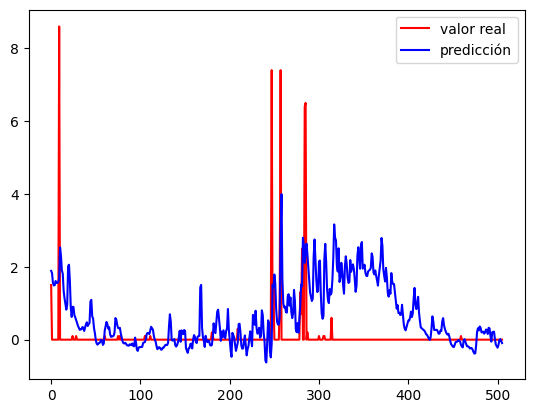

In [204]:
#Gráfica de resultados
plt.plot(fully_final['PRCP'],label='valor real',color='red')
plt.plot(fully_final['final_pr_pred'],label='predicción',color='blue')
plt.legend()